In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm

# URL of your running PromptForest server
SERVER_URL = "http://localhost:1000/analyze"

# Datasets to test accuracy on
DATASETS = [
    {
        "name": "geekyrakshit/prompt-injection-dataset",
        "split": "test",
        "text_cols": ["prompt", "text"],
        "label_col": "label",
    },
    {
        "name": "JasperLS/prompt-injections",
        "split": "test",
        "text_cols": ["text", "prompt"],
        "label_col": "label",
    },
    {
        "name": "deepset/prompt-injections",
        "split": "test",
        "text_cols": ["text", "prompt"],
        "label_col": "label",
    }
]

MAX_SAMPLES = 500

# Pick first non-empty text column
def pick_text(example, candidates):
    for c in candidates:
        if c in example and example[c]:
            return example[c]
    raise ValueError("No valid text column found")

# Send a prompt to the server
def analyse(prompt: str):
    r = requests.post(SERVER_URL, json={"prompt": prompt}, timeout=15)
    r.raise_for_status()
    return r.json()

all_rows = []

for cfg in DATASETS:
    print(f"\nRunning {cfg['name']}")
    ds = load_dataset(cfg["name"], split=cfg["split"])
    ds = ds.shuffle(seed=42).select(range(min(len(ds), MAX_SAMPLES)))

    for ex in tqdm(ds):
        text = pick_text(ex, cfg["text_cols"])
        true_label = int(ex[cfg["label_col"]])
        out = analyse(text)
        pred_label = int(out["is_malicious"])

        all_rows.append({
            "dataset": cfg["name"],
            "true_label": true_label,
            "pred_label": pred_label,
            "confidence": out.get("confidence", np.nan),
        })

# Convert to DataFrame
df = pd.DataFrame(all_rows)
df["correct"] = df["true_label"] == df["pred_label"]

# Accuracy per dataset
accuracy_df = df.groupby("dataset")["correct"].mean().reset_index()
accuracy_df.rename(columns={"correct": "accuracy"}, inplace=True)

print("\nAccuracy per dataset:")
print(accuracy_df)
print("Overall accuracy:", df["correct"].mean())


/Users/28zhany/promptforest/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Running geekyrakshit/prompt-injection-dataset


100%|██████████| 500/500 [00:51<00:00,  9.68it/s]



Running JasperLS/prompt-injections


100%|██████████| 116/116 [00:10<00:00, 11.27it/s]



Running deepset/prompt-injections


100%|██████████| 116/116 [00:09<00:00, 12.67it/s]


Accuracy per dataset:
                                 dataset  accuracy
0             JasperLS/prompt-injections  0.655172
1              deepset/prompt-injections  0.655172
2  geekyrakshit/prompt-injection-dataset  0.782000
Overall accuracy: 0.7418032786885246


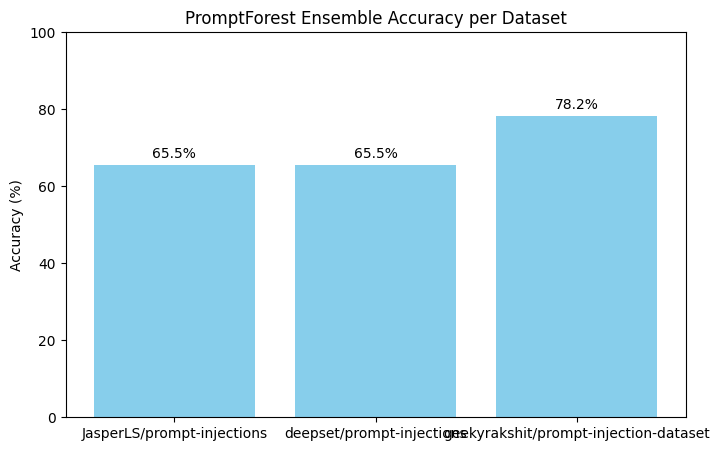

In [2]:
plt.figure(figsize=(8, 5))
plt.bar(accuracy_df['dataset'], accuracy_df['accuracy']*100, color='skyblue')
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("PromptForest Ensemble Accuracy per Dataset")
for i, acc in enumerate(accuracy_df['accuracy']*100):
    plt.text(i, acc + 1, f"{acc:.1f}%", ha='center', va='bottom')
plt.show()